# Day 1: points

We always say France is all about __cheese__ 🧀, let's prove that using maps based on official statistics open-data ! 

This notebook uses the following ressources:

- Sirene data (official firms register) downloaded from the [`API Sirene`](https://api.insee.fr/catalogue/site/themes/wso2/subthemes/insee/pages/item-info.jag?name=Sirene&version=V3&provider=insee) thanks to `Python` package [`pynsee`](https://github.com/InseeFrLab/pynsee)
- Geocoding based on address using [`API BAN`](https://api.gouv.fr/les-api/base-adresse-nationale)
- Official France geographic borders fetched with [`cartiflette`](https://github.com/InseeFrLab/cartiflette) `Python` package

## Preliminary steps

### Dependencies

To install all dependencies required to reproduce and extend this analysis, you need
to install a few packages with the following lines.

If your `pip install` does not know where to find `Git`, you can have a look to an alternative
command at the end of the notebook.

In [ ]:
!pip install -r requirements.txt
!pip install git+https://github.com/inseefrlab/cartogether

<div class="alert alert-info" role="alert">
<h3 class="alert-heading">API Sirene </h3>
The <code>API Sirene</code> is an official French API developped by Insee, the French national statistical office. 
Documentation can be found
<a href="https://api.insee.fr/catalogue/site/themes/wso2/subthemes/insee/pages/item-info.jag?name=Sirene&version=V3&provider=insee">here</a>
(in French).
<br>
If you want to use it, you need to create an account, register to <code>API Sirene</code> service (free) and give 
<code>Python</code> your credentials (see below)
</div>

We propose to put the credentials for `API Sirene` authentification in a `secrets.yaml` file.
This technique, that I teach [here](https://ensae-reproductibilite.netlify.app/application/#configyaml), avoids to share personal credentials in notebooks.  

### Preparing authentification to `API Sirene`

In [2]:
import yaml
import os

with open('secrets.yaml', 'r') as file:
    options = yaml.safe_load(file)

os.environ['insee_key'] = options['insee_key']
os.environ['insee_secret'] = options['insee_secret']

## Getting French borders and French firm level codes

In this section, we propose to fetch some elements that will be useful to be able to produce our maps easily:

1. Get sector code from [French nomenclature of activities (NAF)](https://www.insee.fr/fr/information/2406147). This will
prove useful to only request data we are interested in.
2. Get French official border limits produced by the French institute for Geography (IGN)

We use two experimental packages that are build to help analyzing official statistics data: [`pynsee`](https://github.com/InseeFrLab/pynsee) and
[`cartiflette`](https://github.com/InseeFrLab/cartiflette)

We can get the full nomenclature of activity list using an internal function of `pynsee` package:

In [3]:
import pynsee
naf5 = pynsee.get_activity_list('NAF5')

naf5.sample(5)

This function renders package's internal data


,A10,A129,A17,A21,A38,A5,A64,A88,NAF1,NAF2,NAF3,NAF4,NAF5,TITLE_NAF5_40CH_FR,TITLE_NAF5_65CH_FR,TITLE_NAF5_FR
314,BE,D35A,DE,D,DZ,BE,DZ0,35,D,35,35.1,35.12,35.12Z,Transport d'électricité,Transport d'électricité,Transport d'électricité
496,GI,H50Z,HZ,H,HZ,GU,HZ2,50,H,50,50.1,50.10,50.10Z,Transport maritime & côtier de passagers,Transports maritimes et côtiers de passagers,Transports maritimes et côtiers de passagers
411,GI,G46Z,GZ,G,GZ,GU,GZ2,46,G,46,46.4,46.48,46.48Z,Com. gros artic. horlogerie & bijouterie,Commerce de gros d'articles d'horlogerie et de...,Commerce de gros (commerce interentreprises) d...
568,KZ,K65Z,KZ,K,KZ,GU,KZ2,65,K,65,65.3,65.30,65.30Z,Caisses de retraite,Caisses de retraite,Caisses de retraite
372,GI,G45Z,GZ,G,GZ,GU,GZ1,45,G,45,45.3,45.31,45.31Z,Commerce de gros d'équipement automobile,Commerce de gros d'équipements automobiles,Commerce de gros d'équipements automobiles


If we want to know the code for cheese factories, we can use the following code:

In [4]:
naf5.loc[naf5['TITLE_NAF5_FR'].str.contains('fromage')]

,A10,A129,A17,A21,A38,A5,A64,A88,NAF1,NAF2,NAF3,NAF4,NAF5,TITLE_NAF5_40CH_FR,TITLE_NAF5_65CH_FR,TITLE_NAF5_FR
68,BE,C10E,C1,C,CA,BE,CA0,10,C,10,10.5,10.51,10.51C,Fabrication de fromage,Fabrication de fromage,Fabrication de fromage


Finally, to get the official French borders, we can use `cartiflette` experimental function:

In [5]:
from cartiflette.download import get_vectorfile_ign

france = get_vectorfile_ign(
  level = "REGION",
  field = "metropole",
  source = "COG",
  provider="opendatarchives"
  )
france = france.dissolve()

opendatarchives
COG
Data have been previously downloaded and are still available in /tmp/COG-2022


ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed


We reported some functions to automatize downloads in a `functions.py`

In [6]:
import functions as fc

## Cheese producers map 🧀

Putting together all elements, we can use `matplotlib` and `contextily` features to get a nice
map.

We first fetch the data using Sirene API and transform in `GeoPandas DataFrame` to get a geographic object:

In [ ]:
import geopandas as gpd

geodata_complete = fc.geoloc_data(
    fc.create_dataset_sirene()
)
gdf = gpd.GeoDataFrame(
    geodata_complete,
    geometry=gpd.points_from_xy(geodata_complete['longitude'], geodata_complete['latitude']),
    crs=4326)

Text(0.12, 0.1, 'Twitter: @linogaliana\nSource: IGN - Insee ')

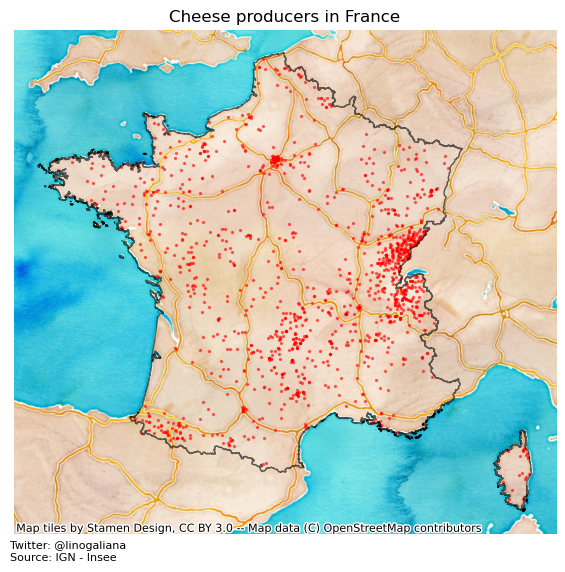

In [19]:
import contextily as ctx
import matplotlib.pyplot as plt

txt="Twitter: @linogaliana\nSource: IGN - Insee "

ax = gdf.to_crs(2154).plot(color = 'red', alpha = 0.5, markersize = 2, figsize = (7,7))
france.plot(ax = ax, zorder=1, edgecolor = "black", alpha = 0.6, facecolor="none",
                                                           color = None)
ctx.add_basemap(ax, source = ctx.providers.Stamen.Watercolor, crs = 2154)
ax.set_axis_off()
ax.set_title('Cheese producers in France')
plt.figtext(.12, .1, txt, wrap=True, horizontalalignment='left', fontsize=8)

## Cows breeders 🐄

Let's go back to the source and have a look at cows breeders (code `01.41Z`).

Note that we will
have look to farmers that declared as main activity being cows breeders. If they 
declared themselves chicken breeders but have some cows, we miss them. 

In [ ]:
geopandas_vaches = fc.geoloc_data(
    fc.create_dataset_sirene("01.41Z", number = 30000)
)
geopandas_vaches = gpd.GeoDataFrame(
    geopandas_vaches,
    geometry=gpd.points_from_xy(geopandas_vaches['longitude'], geopandas_vaches['latitude']),
    crs=4326)

Text(0.12, 0.1, 'Twitter: @linogaliana\nSource: IGN - Insee ')

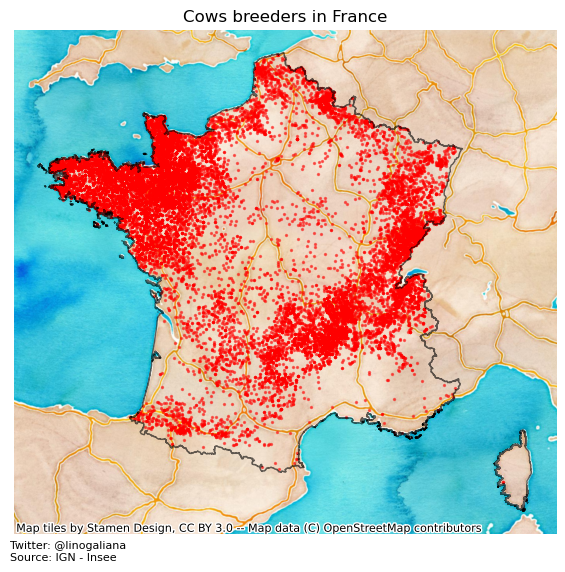

In [21]:
ax = geopandas_vaches.to_crs(2154).plot(color = 'red', alpha = 0.5, markersize = 2, figsize = (7,7))
france.plot(ax = ax, zorder=1, edgecolor = "black", alpha = 0.6, facecolor="none",
                                                           color = None)
ctx.add_basemap(ax, source = ctx.providers.Stamen.Watercolor, crs = 2154)
ax.set_axis_off()
ax.set_title('Cows breeders in France')
plt.figtext(.12, .1, txt, wrap=True, horizontalalignment='left', fontsize=8)

## Camel breeders 🐪

Official statistics is fun because you can find some random information if you dig into. 
Let's have a look at camel breeders. 

In [ ]:
geopandas_chameaux = fc.geoloc_data(
    fc.create_dataset_sirene("01.44Z", number = 2000)
)

In [25]:
geopandas_chameaux.shape

(155, 96)

We have 155 people that declared breeding camels as main activity ! 

Where are they located ? Mostly in South of France

In [27]:
gdf_chameaux = gpd.GeoDataFrame(
    geopandas_chameaux,
    geometry=gpd.points_from_xy(geopandas_chameaux['longitude'], geopandas_chameaux['latitude']),
    crs=4326)

Text(0.12, 0.1, 'Twitter: @linogaliana\nSource: IGN - Insee ')

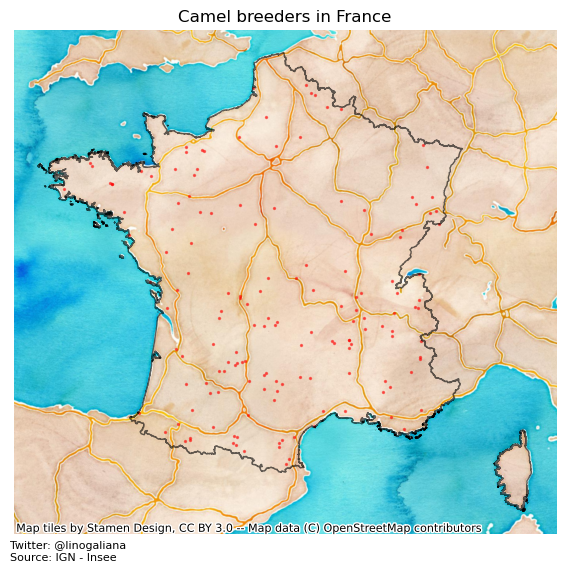

In [29]:
ax = gdf_chameaux.to_crs(2154).plot(color = 'red', alpha = 0.5, markersize = 2, figsize = (7,7))
france.plot(ax = ax, zorder=1, edgecolor = "black", alpha = 0.6, facecolor="none",
                                                           color = None)
ctx.add_basemap(ax, source = ctx.providers.Stamen.Watercolor, crs = 2154)
ax.set_axis_off()
ax.set_title('Camel breeders in France')
plt.figtext(.12, .1, txt, wrap=True, horizontalalignment='left', fontsize=8)

## Appendix: installation troubles with `cartiflette`

If you have troubles using `pip` install directly with `Git`, you can try to make your system using `Git` directly:

In [ ]:
!git clone https://github.com/InseeFrLab/cartogether.git
%cd ./cartogether
!pip install -r requirements.txt
!pip install .